In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the CSV files 
df_energy_a = pd.read_csv('energy_design_a.csv')
df_energy_b = pd.read_csv('energy_design_b.csv')

In [3]:
df_energy_a.head()

,Fuel_Source,Building_Type,Energy_Usage
0,Natural_Gas,Residential,576.997736
1,Biofuel,Commercial,626.838952
2,Natural_Gas,Commercial,542.448624
3,Natural_Gas,Residential,594.053558
4,Natural_Gas,Commercial,413.235891


In [4]:
df_energy_b.head()

,Geographical_Region,Fuel_Source,CO2_Emissions
0,North,Natural_Gas,11.490142
1,North,Natural_Gas,9.585207
2,North,Natural_Gas,11.943066
3,North,Natural_Gas,14.569090
4,North,Natural_Gas,9.297540


This is our dataset of interest as per the goal of the experiment.

In [5]:
df_energy_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Geographical_Region  80 non-null     object 
 1   Fuel_Source          80 non-null     object 
 2   CO2_Emissions        80 non-null     float64
dtypes: float64(1), object(2)
memory usage: 2.0+ KB


In [6]:
df_energy_b.describe()

,CO2_Emissions
count,80.000000
mean,30.715272
std,13.729183
min,9.085912
25%,18.816971
50%,28.718568
75%,39.625307
max,61.044318


In [7]:
df_energy_b.groupby("Geographical_Region")["CO2_Emissions"].mean()

Geographical_Region
East     24.893239
North    19.486104
South    48.670124
West     29.811621
Name: CO2_Emissions, dtype: float64

In [8]:
#plot the distribution of CO2 emissions for df_energy_b using kdeplot
sns.set_style('whitegrid')
sns.kdeplot(df_energy_b['CO2_Emissions'], fill=True)
plt.title('Distribution of CO2 Emissions for Design B')
plt.show()

MemoryError: In RendererAgg: Out of memory

<Figure size 640x480 with 1 Axes>

In [9]:
#test for normality
from scipy.stats import shapiro
stat, p = shapiro(df_energy_b['CO2_Emissions'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.961, p=0.016


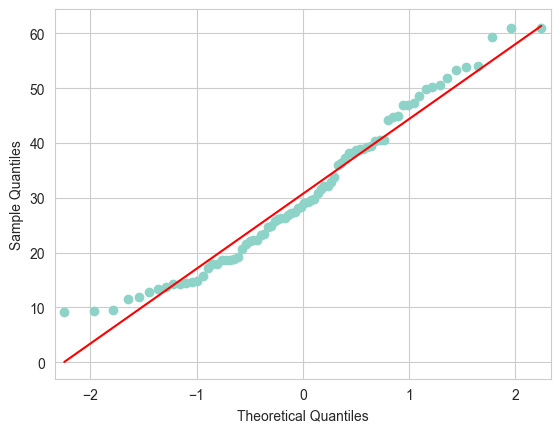

In [10]:
# use qqplot to test for normality
from statsmodels.graphics.gofplots import qqplot
qqplot(df_energy_b['CO2_Emissions'], line='s')
plt.show()

# Visualisation

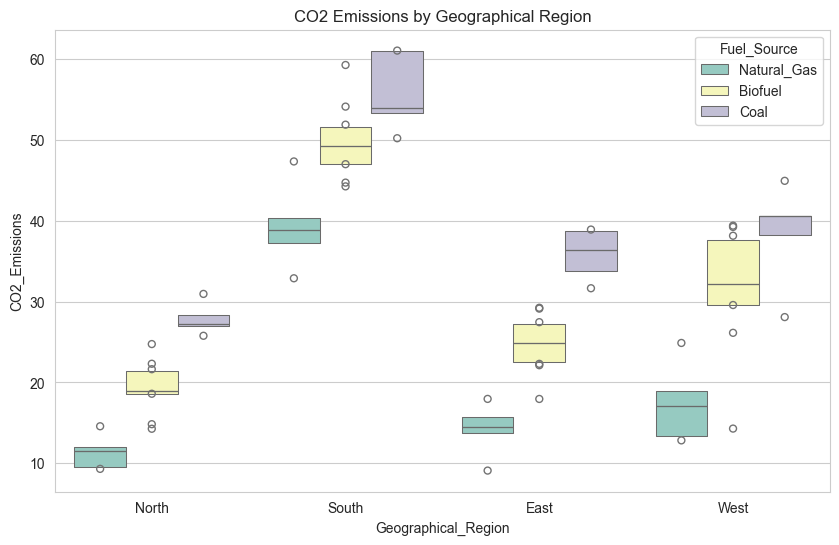

In [11]:
#boxen plot
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Geographical_Region', y='CO2_Emissions', hue= "Fuel_Source", data=df_energy_b)
plt.title('CO2 Emissions by Geographical Region')
plt.show()

The combination of South as the region and Coal as the fuel source has the highest median CO2 emissions value.

In [12]:
#import oneway and tukeyhsd from statsmodels
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform a two-way ANOVA test
regions = df_energy_b['Geographical_Region'].unique()
sources = df_energy_b['Fuel_Source'].unique()
groups = [df_energy_b[(df_energy_b['Geographical_Region'] == region) & (df_energy_b['Fuel_Source'] == source)]['CO2_Emissions'] for region in regions for source in sources]
test_results = f_oneway(*groups)
print("\nTwo-way ANOVA Test Results:")
print(f"F-statistic: {test_results.statistic:.4f}, p-value: {test_results.pvalue:.4f}")


Two-way ANOVA Test Results:
F-statistic: 55.6029, p-value: 0.0000


The two-way ANOVA test indicates a significant difference in CO2 emissions based on fuel source, grouped by region (F-statistic: 55.6029, p-value: 0.0000).

In [13]:
# Perform Tukey's HSD post-hoc test if the ANOVA test is significant
if test_results.pvalue < 0.05:
    tukey_results = pairwise_tukeyhsd(df_energy_b['CO2_Emissions'], df_energy_b['Geographical_Region'] + '-' + df_energy_b['Fuel_Source'])
    diff_results = tukey_results.summary()
    print("\nTukey's HSD Post-hoc Test Results:")
    print(diff_results)
else:
    diff_results = None
    print("\nNo significant difference found, so no post-hoc test performed.")


Tukey's HSD Post-hoc Test Results:
            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1            group2      meandiff p-adj   lower    upper   reject
----------------------------------------------------------------------------
     East-Biofuel         East-Coal  11.1269 0.0026   2.4501  19.8037   True
     East-Biofuel  East-Natural_Gas -10.5331 0.0057 -19.2099  -1.8563   True
     East-Biofuel     North-Biofuel  -5.3867 0.3151 -12.4713   1.6979  False
     East-Biofuel        North-Coal   3.1065 0.9862  -5.5703  11.7833  False
     East-Biofuel North-Natural_Gas -13.3678 0.0001 -22.0446   -4.691   True
     East-Biofuel     South-Biofuel  24.9778    0.0  17.8932  32.0624   True
     East-Biofuel        South-Coal  31.1522    0.0  22.4754   39.829   True
     East-Biofuel South-Natural_Gas  14.5935    0.0   5.9167  23.2703   True
     East-Biofuel      West-Biofuel   6.9429 0.0599  -0.1417  14.0275  False
     East-Biofuel         West-Coal  13.

In [14]:
#Apply the Bonferroni correction
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(df_energy_b['CO2_Emissions'], df_energy_b['Geographical_Region'])
result = mc.allpairtest(f_oneway, method='bonf')
print(result[0])

Test Multiple Comparison f_oneway 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
group1 group2   stat    pval  pval_corr reject
----------------------------------------------
  East  North    5.106 0.0297     0.178  False
  East  South  86.9108    0.0       0.0   True
  East   West   2.7679 0.1044    0.6264  False
 North  South 169.8027    0.0       0.0   True
 North   West  14.7044 0.0005    0.0028   True
 South   West  44.2921    0.0       0.0   True
----------------------------------------------
